# Effect of Dither and ACIS Frame Time on Subpixel Spatial Resolution

## Question: How small can I bin with ACIS subpixel data?

This question comes up from time to time.  ACIS sky coordinates, `X,Y`, are stored as real, floating-point, values. Some users, trying to maximize the instrument's spatial resolution, wonder if there are any limits on how small a bin size they can use.  Half a pixel? Quarter? Tenth? Hundredth (no)?

There are numerical limits due to the precision of the how the data are stored.  The values are stored as 4-byte floats which is give precision in the ~1e-7 range.  However, there are stricter practical limits due to the actual observation itself.  


## Why?  Because Chandra dithers.

> Users are referred to the [Chandra Proposers' Observatory Guide](https://cxc.cfa.harvard.edu/proposer/POG/html/) for details. Dither is discussed in multiple chapters include the Pointing Control and Aspect Determination (PCAD) chapter as well as the ACIS chapter.

Chandra dithers during an observation (usually). The pointing of the telescope is intentionally programmed to follow a lissajous.  

But, it dithers slowly.  The default dither rate for ACIS is approximately $16*\sqrt2$ arcsec / 707 sec = 0.032 arcsec/sec.

The ACIS pixel size is 0.492 arcsec square.

The aspect solution is computed every 0.256 seconds (usually).

ACIS obtains data by integrating an exposure for ~`TIMEDEL` seconds.  This varies with the size of any subarray readout combined with the number of active CCDs. A typical 6-chip, full-frame ACIS observation has TIMEDEL=3.2 seconds.

All events detected during that time interval are given a `TIME` value equal to the middle of that interval.

However, Chandra dithers.

A fixed source on the sky will move across the CCD during the `TIMEDEL` seconds, essentially blurring the source.

The dither is slow compared to the ACIS exposure time; but at subpixel resolutions, the effect may be of concern.


This notebook shows how to quantify this effect.

## Setup



In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pycrates import read_file
import numpy as np

## Download Data

Some useful variables we'll use throughout this notebook

In [3]:
OBS_ID = "3141"
CCD_ID = "7"
N_SIGMA = 1
TIME_LO = 5000
TIME_HI = 5008

Download the data we need

In [4]:
from ciao_contrib.cda.data import download_chandra_obsids
download_chandra_obsids([OBS_ID], filetypes=["asol","stat"]);

Locate the files we'll need

In [5]:
import glob
asol1=glob.glob(OBS_ID+"/primary/pcad*asol1.fits.gz")
assert len(asol1) == 1, "Only single asol file supported"
asol1 = asol1[0]

stat1=glob.glob(OBS_ID+"/secondary/acisf*stat1.fits.gz")
assert len(stat1) == 1, "Only single stat1 file supported"
stat1 = stat1[0]

## Event times vs. Aspect Times

ACIS and PCAD are independent instruments that generate data on independent time grids.

ACIS typically produces data every ~3.2 seconds (varies with number of active chips and if subarrays were used).

PCAD typically produces data every ~0.256 seconds, but may be as long as 32 seconds depending on the telemetry format.

When converting from instrument coordinate to sky coordinates, `acis_process_events`, `tg_resolve_events`, and `hrc_process_events` use the last aspect solution time record before the time of the event.


`libdev/lev1/l1_asplib/l1_aspect_function.c` :

```C
/*
* FUNCTION NAME: aspect_update()
 
* DESCRIPTION:

    The routine aspect_update is called upon by [foo]_process_events to   
    update the pixel library's aspect values as necessary. The routine is 
    called once for each event and uses the event's time field to determine 
    whether or not the aspecting position needs to be adjusted. If so, it 
    will search through the aspect file (or a stack of aspect files) for a
    time interval that encompasses the current event's timestamp. As it 
    does so the pixel library is called and updated for all aspect 
    positions whose time ranges occur before the event's time. 

```

### Aspect Solution

First, let's load and look at the aspect solution.

The `TIMEDEL` keyword is the time between aspect solution records.

The `TIMEPIXR` keyword is used to indicate whether the `TIME` values are for the beginning (`0`), the middle (`0.5`), or the end (`1`) of the time interval.

In [6]:
asp = read_file(asol1)
asp_times = asp.get_column("time").values
asp_deltaT = asp.get_key_value("timedel")
asp_Tpixr = asp.get_key_value("timepixr")

print(f"ASOL deltaT = {asp_deltaT}")
print(f"ASOL Tpixr = {asp_Tpixr}")


ASOL deltaT = 0.25625
ASOL Tpixr = 0.0


Okay, so these aspect solution records are ~0.256s apart and the times are for the beginning of the time interval.

### Look at the event times

Well, we will look at the time in the _event statistics_ aka `stat1` file.  

The event file only has times when there are actually events.  The `stat1` files contains the
time tags for each ACIS exposure whether there are any events or not.

We need to know the `CCD_ID` because each chip is actually read out at different time.  That is exposure number, `EXPNO`, 10 on `CCD_ID=7` will have a different `TIME` value than `EXPNO=10` on `CCD_ID=6`.  

In [7]:
# Repeat for the STAT1 file.

st = read_file(stat1+f"[ccd_id={CCD_ID}]")
st_times = st.get_column("time").values
st_deltaT = st.get_key_value("timedel")
st_Tpixr = st.get_key_value("timepixr")
print(f"EVT deltaT = {st_deltaT}")
print(f"EVT Tpixr = {st_Tpixr}")

EVT deltaT = 3.24104
EVT Tpixr = 0.5


These are typical values for ACIS taking full frame data with 6 active CCDs.

Okay now let's plot the ASOL and EVT times to compare them.

In [8]:
# To make the plot cleaner we will subtract off a common time from all the data.

T0 = asp_times[0]

In [9]:
# Make a little helper routine to plot the data.

def plot_times(T0, times, delta, pixr, shift=0):
    'Plot times offset from t0. Fixed Y-values'
    xx = times-T0
    yy = np.ones_like(xx)+shift
    yerr = np.zeros_like(xx)
    xx_err_lo = np.zeros_like(xx)+pixr*delta
    xx_err_hi = np.zeros_like(xx)+(1-pixr)*delta

    plt.errorbar(xx,yy,yerr=(yerr,yerr),xerr=(xx_err_lo,xx_err_hi),
                 capsize=10,marker="s",linestyle='none')


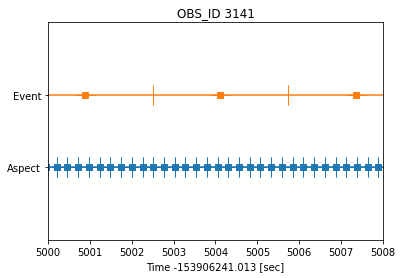

In [10]:
plot_times(T0, asp_times, asp_deltaT, asp_Tpixr, shift=0)
plot_times(T0, st_times, st_deltaT, st_Tpixr, shift=1)

plt.title("OBS_ID "+OBS_ID)
plt.xlabel(f"Time -{T0:.3f} [sec]")
plt.yticks([1,2], ['Aspect','Event'])
plt.ylim( 0, 3 )
plt.xlim(TIME_LO,TIME_HI);


The squares show the `TIME` value from the aspect solution and event statistics file.  The vertical bars show the start/stop time for the interval containing the event|aspect time.

**All events recorded during the exposure are all given the same `TIME` value**.

As we see here, there are multiple aspect solution data points that are recorded during any ACIS exposure.

We do not know **when** during the ACIS exposure the event was recorded, therefore there is some uncertainty in the aspect reconstruction.  We would like to know the size of this uncertainty.


## Identify aspect records

We can replicate the `l1_asp::aspect_update` logic here to identify which aspect records were **the** records that were used to reconstruct the event position.  

> The other aspect records are ignored.

The logic is fairly simple.  The *last* aspect records that *occurred* before the event time is used.  

> There is a bit of extra logic to deal with the beginning of an observation where there may be event data but no aspect solution.  However, there is no special handling of the end of the observation; the last aspect record is used for all events that occur after it.  But note: those times are removed from the Level2 event file.


In [11]:
# Identify which ASOL time was used for each ACIS exposure

used_asol_times = []
for tt in st_times:
    less_than = asp_times[asp_times<=tt]
    try:
        used_asol_times.append(less_than[-1])
    except:
        used_asol_times.append(np.nan)
xx = np.array(used_asol_times)-T0
yy = np.ones_like(used_asol_times)

Okay now let's repeat the earlier plot but now show which ASOL time values were actually used.

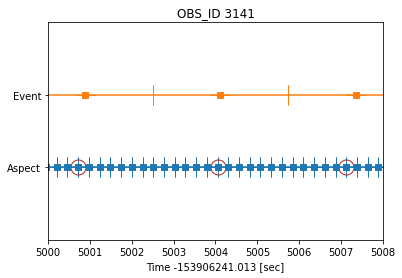

In [12]:
plot_times(T0, asp_times, asp_deltaT, asp_Tpixr, shift=0)
plot_times(T0, st_times, st_deltaT, st_Tpixr, shift=1)

plt.title("OBS_ID "+OBS_ID)
plt.xlabel(f"Time -{T0:.3f} [sec]")
plt.yticks([1,2], ['Aspect','Event'])
plt.ylim( 0, 3 )
plt.xlim(TIME_LO,TIME_HI)

plt.plot(xx,yy,marker="o",linestyle="none",mec="firebrick",markersize=15,fillstyle="none");

So the way it works is that all the events within the Event time interval are all given the same event time.  For example consider the event with offset time ~= 5004.  The events are detected during a single exposure -- but we don't know when within the exposure they were detected so they all get the time of the middle of the exposure.

All these events will use the same aspect solution record at the time shown (just before ~5004).   Any events detected near the middle of the exposure frame time will have an accurate aspect solution; which events detected at the beginning and end of the exposure suffering from inaccurate aspect solution.

## How much does aspect solution change during an ACIS exposure?


Now that we know which aspect solution records are used, we now want to understand how much does the aspect solution change during each exposure relative to the record that was used.  Our back-of-the-envelope calculation is 0.0322 arcsec/sec * 3.2 sec = 0.1 arcsec (about 1/5 of an ACIS pixel), but we can look at the data to get a better estimate.

We can take a quick look at just the raw `RA` and `DEC` values during this time interval.  We'll plot relative to some nominal value, we'll just pick the median `ra`/`dec` to see the magnitude of the change.



In [13]:
ra = asp.get_column("ra").values
dec = asp.get_column("dec").values

nn = np.bitwise_and( asp_times-T0 >=TIME_LO, asp_times-T0 <= TIME_HI)

med_ra = np.median(ra[nn])
med_dec = np.median(dec[nn])

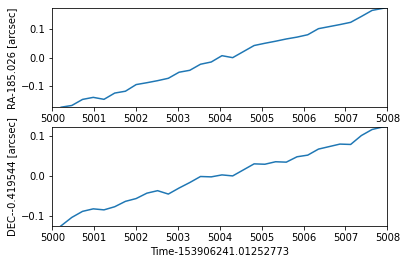

In [14]:
# -- Plot ra
plt.subplot(2,1,1)
plt.plot( asp_times-T0, (ra-med_ra)*3600)
plt.xlim(TIME_LO,TIME_HI)

plt.ylabel(f"RA-{med_ra:.6} [arcsec]")
yl = np.min(ra[nn]-med_ra)*3600
yh = np.max(ra[nn]-med_ra)*3600
plt.ylim(yl,yh) 

# -- Plot dec
plt.subplot(2,1,2)
plt.plot(asp_times-T0, (dec-med_dec)*3600)
plt.ylabel(f"DEC-{med_dec:.6} [arcsec]")
plt.xlabel(f"Time-{T0}")
yl = np.min(dec[nn]-med_dec)*3600
yh = np.max(dec[nn]-med_dec)*3600
plt.ylim(yl,yh)
plt.xlim(TIME_LO,TIME_HI);

It's hard to see from the above plot the magnitude of the change, especially relative to the ACIS pixel size (0.492 arcsec/pixel).

## Compute distance

Instead we can compute the distance from each aspect record relative to the aspect record used to reconstruct the event position.  

Since we want to understand the worst case situation, we compute the **maximum** distance between any aspect point in the event time interval (relative to the record used to reconstruct the event position).  

> The best case scenario is that events were detect in the 0.256s interval actually used.

In [15]:
# Use cos(dec) approximation for dist calcs
dec_nom = asp.get_key_value("DEC_NOM")
cos_dec = np.cos( np.deg2rad(dec_nom))

dra_plot = []
ddec_plot = []
max_offset = []
for tt,ut in zip(st_times,used_asol_times):
    # Determine range of asol files around the event time
    lo = tt - st_Tpixr*st_deltaT
    hi = tt + (1.0-st_Tpixr)*st_deltaT
    rr = np.bitwise_and( asp_times >= lo, asp_times < hi)

    # Get the ra & dec value actually used
    used_ra = ra[asp_times==ut]
    used_dec = dec[asp_times==ut]

    # Compute offset, store in arcsec
    dra = (ra[rr]-used_ra)*cos_dec
    ddec = (dec[rr]-used_dec)

    try:
        dra_plot.extend( list(dra*3600))
        ddec_plot.extend(list(ddec*3600))        
    except:
        pass
        
    dist = np.hypot(dra, ddec)
    try:
        max_offset.append(np.max(dist)*3600.0)
    except:
        max_offset.append(np.nan)

We can plot the distance offset during each exposure as a scatter plot to see the type of aspect reconstruction error we might expect to see

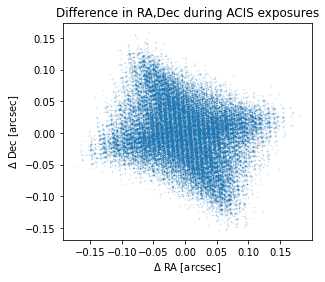

In [16]:
plt.plot( dra_plot, ddec_plot, linestyle="none", marker=".",alpha=0.2,markersize=1)
plt.xlabel("$\Delta$ RA [arcsec]")
plt.ylabel("$\Delta$ Dec [arcsec]")
plt.title("Difference in RA,Dec during ACIS exposures")

# Make plot square
plt.gca().set_aspect(1)

> Reminder: 1 ACIS pixel is ~ 0.492" square.

We can also plot the cumulative distribution of distances based on the above scatter data.  As a metric we can use for comparison we also compute the 1$\sigma$ interval -- ie the distance within which we find 68% of the points.

In [17]:
big_d = np.hypot( dra_plot, ddec_plot)
big_d.sort()
sum_d = np.cumsum(big_d)
sum_d = sum_d/max(sum_d)

from math import erf,sqrt
sigma = erf(N_SIGMA/sqrt(2))
one_sigma_idx, = np.where(sum_d<sigma)
one_sigma = big_d[one_sigma_idx[-1]]

print(f"{N_SIGMA}𝛔 = {one_sigma:.4f}")

1𝛔 = 0.0897


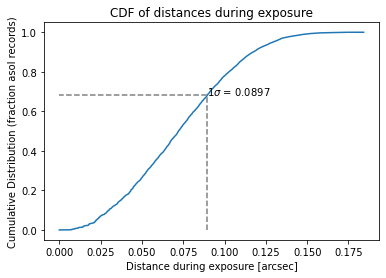

In [18]:
plt.plot( big_d, sum_d)

plt.plot( [one_sigma, one_sigma, 0.0],
          [0, sigma, sigma], color="gray", linestyle="--")

plt.text( one_sigma, sigma, f"{N_SIGMA}$\sigma$ = {one_sigma:.4f}")

plt.xlabel("Distance during exposure [arcsec]")
plt.ylabel("Cumulative Distribution (fraction asol records)")
plt.title("CDF of distances during exposure");

Finally, we can take a look at the worst case scenario -- the max offset during each exposure

Now create histogram of the MAXIMUM during the exposure

In [19]:
hh = np.histogram( max_offset, bins=50, range=[0,0.5])

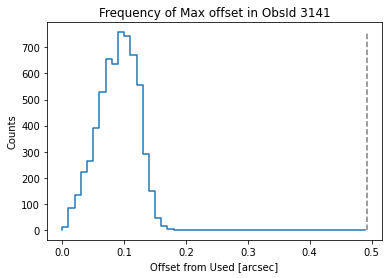

In [20]:
plt.step(hh[1][:-1],hh[0])

plt.vlines(0.492, 0, max(hh[0]), linestyle="--", color="gray")  # ACIS pixel size

plt.xlabel("Offset from Used [arcsec]")
plt.ylabel("Counts")
plt.title("Frequency of Max offset in ObsId "+OBS_ID);

Basically this shows that the aspect solution moves by around 0.09" during any particular exposure which is about 0.2 of a pixel.  This is consistent with our back-of-the-envelope estimate.

## Answer:

For this particular dataset, uses should be cautious when they choose a binsize of 0.2 pixels or smaller. 

Since a source will move this amount during an ACIS exposure, it may impart some spatial structure onto the source morphology. It may be just a general blurring or possibly some directional extent. The exact effect is unknown.




## Final thoughts: ChaRT & MARX

It's worth noting that ChaRT and MARX will use the aspect file that is supplied.  All of it.  Every row.

Unlike `acis_process_events` which doesn't know when during a 3.2 second exposure an event lands; ChaRT and MARX know exactly what time tag they simulated and use the right asol record to match that.

Therefore, this effect is not something encapsulated in the calibration of the PSF.
